In [1]:
import src.generation.gamma as ga
import src.generation.multivariate_normal as mn

from src.salp.salp import SALP
from src.salp.salp import Node

from src.algorithms.round_robin import RoundRobin
from src.algorithms.best_fit import BestFit

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# funkcja do produkowania wykresów obciążenia węzłów

def plot_node_load(n: Node, estimated_node_load: float = None, actual_mean_node_load: float = None, node_power: float = None):
    size = n.ws.size
    plt.bar(
        np.arange(size),
        n.ws
    )
    plt.title("Node {}".format(n.identity))
    if estimated_node_load:
        plt.hlines(estimated_node_load, xmin=0-1, xmax=size, colors='r')
    if actual_mean_node_load:
        plt.hlines(actual_mean_node_load, xmin=0-1, xmax=size, colors='g', linestyle='dashed')
    if node_power:
        plt.hlines(node_power, xmin=0-1, xmax=size, colors='orange')
    plt.show()

In [3]:
from typing import List

def calculate_total_node_queueing_time(n: Node, power: float) -> float:
    stb = np.mean(n.ws)/power
    assert stb < 1, "Node {} is not stable".format(n.identity)
    coeff = stb/(1-stb)
    return coeff * np.sum(n.ws)
    
def calculate_all_nodes_queueing_time(nodes: List[Node], power: float) -> float:
    total_ct = 0
    for n in nodes:
        ct = calculate_total_node_queueing_time(n, node_power)
        total_ct += ct
    return total_ct

In [4]:
# TODO algorithms
# SALP
def salp_wrapper(N: int, load_vectors):
    return SALP(N, load_vectors, False)
# Best Fit
def bf_wrapper(N: int, load_vectors):
    return None
# Round robin
def rr_wrapper(N: int, load_vectors):
    return RoundRobin(N, load_vectors, False)

algorithms = [
    ('SALP', salp_wrapper),
    ('BF', bf_wrapper),
    ('RR', rr_wrapper),
]

## Example pipeline

Estimated minimal node power 30.0
Node power 37.5
Actual mean node load 30.973703544964387
-----------------------
Node 0: 0.7581467809983301 891.2221799921979


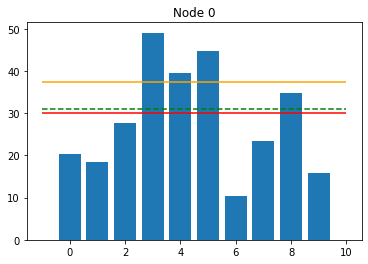

Node 1: 0.8497393049165273 1802.010380822409


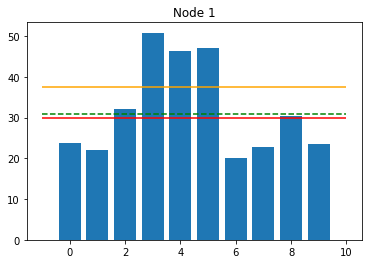

Node 2: 0.8166611658978215 1364.1452378698423


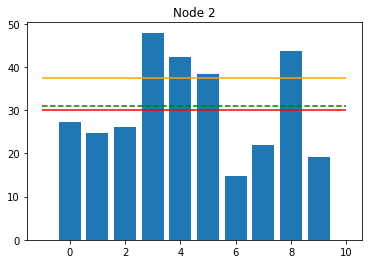

Node 3: 0.8793144596501895 2402.5058740739983


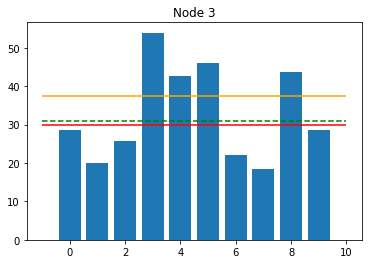

In [5]:
def pipeline(F: int, N: int, size: int, cor: float, ro: float, rng = (2,4)):
    
    generator = ga.Generator(F, size, cor, rng)
    
    estimated_load = generator.get_estimated_cloud_load()
    estimated_node_load = estimated_load/size/N
    print("Estimated minimal node power", estimated_node_load)
    
    node_power = estimated_node_load/ro
    print("Node power", node_power)
    
    load_vectors = generator.generate_cloud_load_vectors()
    actual_mean_node_load = np.sum(load_vectors)/size/N
    print("Actual mean node load", actual_mean_node_load)
    
    cloud = SALP(N, load_vectors, False)
    assert len(cloud.nodes) == N
    
    print('-----------------------')
    
    for n in cloud.nodes:
        ct = calculate_total_node_queueing_time(n, node_power)
        print("Node {}:".format(n.identity), np.mean(n.ws)/node_power, ct)
        plot_node_load(n,estimated_node_load,actual_mean_node_load, node_power)
    
    
pipeline(20, 4, 10, 0.5, 0.8)

### Walidacja SALP

----------------DESCRIPTION----------------
Shards:
[[3 1]
 [3 1]
 [3 1]
 [1 3]
 [1 3]
 [1 3]]

WTS:
[12 12]

NWTS:
[6. 6.]

LW:
[(0, 3.1622776601683795), (1, 3.1622776601683795), (2, 3.1622776601683795), (3, 3.1622776601683795), (4, 3.1622776601683795), (5, 3.1622776601683795)]


----------------ASSIGNMENT----------------
Shard ID: 0
Shard: [3 1]

	Node ID: 0
	Delta: 2.654329479393269

	Node ID: 1
	Delta: 2.654329479393269

Shard ID: 1
Shard: [3 1]

	Node ID: 0
	Delta: 1.8309518948453007

	Node ID: 1
	Delta: 2.654329479393269

Shard ID: 2
Shard: [3 1]

	Node ID: 0
	Delta: 1.8309518948453007

	Node ID: 1
	Delta: 1.8309518948453007

Shard ID: 3
Shard: [1 3]

	Node ID: 0
	Delta: 2.585786437626905

	Node ID: 1
	Delta: 3.0025247700991105

Shard ID: 4
Shard: [1 3]

	Node ID: 0
	Delta: 2.585786437626905

	Node ID: 1
	Delta: 1.4142135623730951

Shard ID: 5
Shard: [1 3]

	Node ID: 1
	Delta: 1.4142135623730951

----------------FINAL NODES----------------
Node: 0
	Shards assigned [FS]: [0 2 4]
	

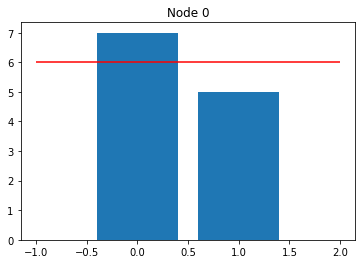

Node 1: 1.0


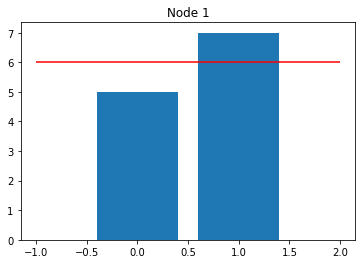

In [6]:
N = 2 # try with n=3 <3
size = 2
instance = np.array([[3,1],[3,1],[3,1],[1,3],[1,3],[1,3]])
cloud = SALP(N,instance, True)
load = np.sum(instance)
mean_node_load = load/N/size

for n in cloud.nodes:
    # stabilność
    print("Node {}:".format(n.identity), np.mean(n.ws)/mean_node_load)
    plot_node_load(n, mean_node_load)

### Walidacja RR

Shard 0 [3 1] to Node 0 node lw [3. 1.]
Shard 1 [3 1] to Node 1 node lw [3. 1.]
Shard 2 [3 1] to Node 0 node lw [6. 2.]
Shard 3 [1 3] to Node 1 node lw [4. 4.]
Shard 4 [1 3] to Node 0 node lw [7. 5.]
Shard 5 [1 3] to Node 1 node lw [5. 7.]
Node 0: 1.0


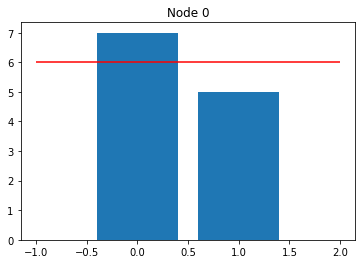

Node 1: 1.0


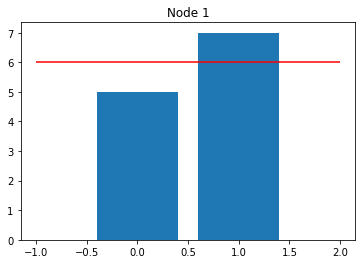

In [7]:
N = 2 # try with n=3 <3
size = 2
instance = np.array([[3,1],[3,1],[3,1],[1,3],[1,3],[1,3]])
cloud = RoundRobin(N,instance, True)
load = np.sum(instance)
mean_node_load = load/N/size

for n in cloud.nodes:
    # stabilność
    print("Node {}:".format(n.identity), np.mean(n.ws)/mean_node_load)
    plot_node_load(n, mean_node_load)

### Walidacja Best Fit

6.0
[(0, 2.0), (1, 2.0), (2, 2.0), (3, 2.0), (4, 2.0), (5, 2.0)]
all asigned
Node 0: 1.0


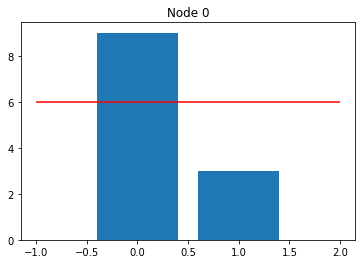

Node 1: 1.0


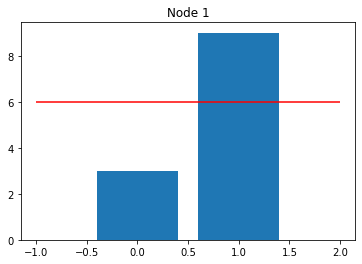

In [21]:
def best_fit2(n: int, shards: np.ndarray):
    
    node_mean_load = np.sum(shards) / n / shards.shape[1]
    print(node_mean_load)
    
    nodes = [Node(e) for e in range(0, n)]
    ss = [(i, v) for i, v in enumerate(np.mean(shards, axis=1)) ]
    ss.sort(key=lambda x: x[1], reverse=True)
    usd = [False for _ in range(len(ss))]
    print(ss)
    
    tolerance = node_mean_load * 0.1 # zakładamy, ze node może zostać przepełniony o 10%
    for node in nodes:
        for i, m in ss:
            if usd[i]:
                continue
            nl = np.mean(node.ws)
            if nl + m < node_mean_load + tolerance:
                node.shard_append(i, shards[i])
                usd[i] = True
            if all(usd):
                print("all asigned")
                break
    if not all(usd):
        print("Error")
        # TODO assign remaining nodes with first fit
    return nodes

N = 2
size = 2
instance = np.array([[3,1],[3,1],[3,1],[1,3],[1,3],[1,3]])
mean_node_load = load/N/size
nds = best_fit2(N, instance)

for n in nds:
    print("Node {}:".format(n.identity), np.mean(n.ws)/mean_node_load)
    plot_node_load(n, mean_node_load)

# Parametry dla iteracji
* F - ilość shardów
* N - ilość węzłów
* cor - poziom korelacji miedzy wektorami obciążenia
* ro - poziom obciążenia chmury
* size - długość wektorów obciążenia
* repeats - ilość powtórzeń pojedynczej symulacji
* parametry generatora do ustalenia

In [ ]:
N = 100
F = 10*N
cor_range = np.arange(0.0, 1.01, 0.5)
load_range = [0.8, 0.9]
size=100
repeats=5
rng = (2,4)

In [ ]:
for cor in cor_range:
    
    generator = ga.Generator(F, size, cor, rng)
    
    estimated_load = generator.get_estimated_cloud_load()
    estimated_node_load = estimated_load/size/N
    print("Estimated node load", estimated_node_load)
    
    for ro in load_range:
        
        node_power = estimated_node_load/ro
        
        for _ in range(repeats):
            
            load_vectors = generator.generate_cloud_load_vectors()
#             actual_mean_node_load = np.sum(load_vectors)/size/N
#             print("Actual mean node load", actual_mean_node_load)
            
            # TODO test all algorithms here
            cloud = SALP(N, load_vectors, False)
            total_ct = calculate_all_nodes_queueing_time(cloud.nodes, node_power)
            
            print(cor, ro, total_ct)